In [ ]:
# Importing the libraries
import io
import sklearn # This is only used for feature selection
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import pickle
import timeit

#this is to import data files into colab AA
from google.colab import files
uploaded = files.upload()
data_bank = pd.read_csv(io.BytesIO(uploaded['bankrupcy.csv']))
data_hep =pd.read_csv(io.BytesIO(uploaded['hepatitis.csv']))

Saving bankrupcy.csv to bankrupcy (3).csv
Saving hepatitis.csv to hepatitis (3).csv


Dimension of X is (142, 20) ; subsequently the dimension of y is (142, 1)
The 1 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively


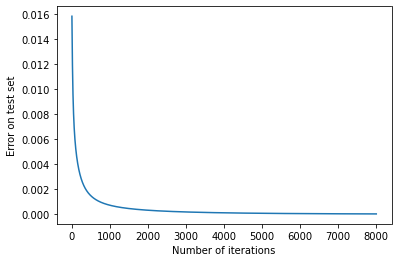

The 2 th fold error and accuracy are 0.0 and 100.0 respectively
The 3 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively
The 4 th fold error and accuracy are 0.0 and 100.0 respectively
The 5 th fold error and accuracy are 0.0 and 100.0 respectively
The 6 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively
The 7 th fold error and accuracy are 0.0 and 100.0 respectively
The 8 th fold error and accuracy are 42.857142857142854 and 57.14285714285714 respectively
The 9 th fold error and accuracy are 28.57142857142857 and 71.42857142857143 respectively
The 10 th fold error and accuracy are 0.0 and 100.0 respectively
The total error and accuracy of this model are 11.428571428571427 and 88.57142857142857 respectively
Time:  2.9414938509980857
# of Iterations: 8000


In [ ]:
# This function randomly distributes the rows of training data
def data_rnd_distribute(x, y, rnd_rows):
    # # creat a random order for rows
    # rnd_rows = random.sample(range(x.shape[0]), x.shape[0])
    # Initialize new X and y matrices
    x_new = np.empty((0, x.shape[1]), float)
    y_new = np.empty((0, 1), float)
    # put each row in sequel
    for j in range(len(rnd_rows)):
        row_ = x[rnd_rows[j], :]  # jth random row
        class_ = y[rnd_rows[j]]  # jth random class
        row_ = np.c_[row_]  # transform into numpy array
        class_ = np.c_[class_]  # transform into numpy array
        # Add the new row and class
        x_new = np.append(x_new, row_.T, axis=0)
        y_new = np.append(y_new, class_, axis=0)
    return x_new, y_new


def normalize_data(in_data):
    x = in_data[:, 0:-1]  # first remove the dummy features
    features_mean = []
    features_std_deviation = []
    for i in range(x.shape[1]):
        feature_i_mean = x[:, i].mean()  # calculate mean of each attribute set
        feature_i_std_deviation = np.std(x[:, i])  # calculate standard deviation of each attribute set
        # feature_i_std_deviation = x[:, i].max() - x[:, i].min()
        features_mean.append(feature_i_mean)
        features_std_deviation.append(feature_i_std_deviation)

    # converting list to numpy array
    features_mean = np.asarray(features_mean)
    features_std_deviation = np.asarray(features_std_deviation)

    x_norm_ = (x - features_mean) / features_std_deviation
    x_norm = np.c_[x_norm_, np.ones((x_norm_.shape[0], 1))]  # Adding the dummy features back to the data set
    return x_norm


def set_order(in_data, order):
    data = in_data[:, 0:-1]  # first remove the dummy features
    if order <= 1:
        data_new = data
    else:
        data_new = data
        i = 2
        while i <= order:
            data_new = np.hstack((data ** i, data_new))
            i = i + 1
    data_new = np.c_[data_new, np.ones((data_new.shape[0], 1))]  # Adding the dummy features back to the data set
    return data_new


# Import data
def get_data(data_path):
    data = pd.read_csv(data_path)
    return data


def sigmoid(variable):
    # The Sigmoid function
    return 1 / (1 + np.exp(-variable))


def gradient_vector(x, y, w, rig_reg, l2_pen):
    # Computes the gradient of the cost function at the point theta
    z = np.dot(x, w)
    if rig_reg:
        dw = 2 * np.dot(x.T, sigmoid(z) - y) + 2 * l2_pen * w
    else:
        dw = np.dot(x.T, sigmoid(z) - y)
    return dw


class LogisticReg:
    def __init__(self, adaptive_iteration, epsilon, beta, alpha, num_it, k, x, y, rig_reg, l2_pen):
        self.alpha = alpha
        self.epsilon = epsilon
        self.beta = beta
        self.x = x
        self.y = y
        self.w = np.zeros((self.x.shape[1], 1))  # Initializing vector of weights
        self.it_list = []
        self.err_list = []
        self.k = k
        self.num_it = num_it
        self.adaptive_iteration = adaptive_iteration
        self.rig_reg = rig_reg
        self.l2_pen = l2_pen

    def fit(self):
        it_list = []
        err_list = []
        it = 1  # initializing the iterations

        if self.adaptive_iteration:
            # Initializing err
            err = self.epsilon + 0.5
            while err >= self.epsilon:
                self.alpha = 1 / (1 + self.beta * it) 
                delta = gradient_vector(self.x, self.y, self.w, self.rig_reg, self.l2_pen)
                w_old = self.w  # store w for comparison
                self.w = self.w - self.alpha * delta
                err = np.linalg.norm(self.w - w_old)  # Calculate the norm-2 of the difference
                it_list.append(it)
                err_list.append(err)
                it += 1

        else:
            for i in range(self.num_it):
                delta = gradient_vector(self.x, self.y, self.w, self.rig_reg, self.l2_pen)
                w_old = self.w  # store w for comparison
                self.w = self.w - self.alpha * delta
                err = np.linalg.norm(self.w - w_old)  # Calculate the norm-2 of the difference
                it_list.append(it)
                err_list.append(err)
                it += 1
        self.it_list = it_list
        self.err_list = err_list
        return self.w, self.it_list, self.err_list

    def predict(self, x):
        z = np.dot(x, self.w)
        return sigmoid(z)


def cross_validate(adaptive_iteration, rig_reg, l2_pen, epsilon, beta, alpha, num_it, k, x, y):
    total_err = []
    total_acc = []
    data = np.c_[x, y]
    fold_size = math.ceil(data.shape[0] / k)  # round up the fold size
    training_set_size = (k - 1) * fold_size
    validation_set_size = data.shape[0] - training_set_size
    for i in range(k):
        data_validation = data[fold_size * i: fold_size * i + validation_set_size, :]
        if i == 0:
            data_training_upper = np.empty((0, data.shape[1]), float)
        else:
            data_training_upper = data[0: fold_size * i, :]
        if i == k - 1:
            data_training_lower = np.empty((0, data.shape[1]), float)
        else:
            data_training_lower = data[fold_size * i + validation_set_size: data.shape[0], :]

        # In following  you can check if assembly of the matrices we obtained are actually same as original data *******
        # data_assem = np.concatenate((data_training_upper, data_validation, data_training_lower), axis=0)
        # x_assem = data_assem[:, 0: self.X.shape[1]]  # separate the features and classes again
        # print('x assem and its shape are:', x_assem, 'and', x_assem.shape)
        # y_assem = data_assem[:, -1]
        # y_assem = np.c_[y_assem]
        # print('y assem and its shape are:', y_assem, 'and', y_assem.shape)
        # print('x dif is', x_assem - self.X)  # should be zero matrix
        # print('y dif is', y_assem - self.y)  # should be zero vector
        # **************************************************************************************************************

        data_training = np.concatenate((data_training_upper, data_training_lower), axis=0)
        x_training = data_training[:, 0: x.shape[1]]  # separate the features and classes
        y_training = data_training[:, -1]
        y_training = np.c_[y_training]  # make y_training a (n,1) vector instead of (n,)

        x_validation = data_validation[:, 0: x.shape[1]]  # separate the features and classes
        y_validation = data_validation[:, -1]
        y_validation = np.c_[y_validation]  # make y_training a (n,1) vector instead of (n,)

        model = LogisticReg(adaptive_iteration, epsilon, beta, alpha, num_it, k, x_training, y_training, rig_reg, l2_pen)
        w_, it_list, err_list = model.fit()
        y_guessed = model.predict(x_validation)

        for j in range(len(y_guessed)):
            if y_guessed[j] < 0.5:
                y_guessed[j] = 0
            else:
                y_guessed[j] = 1

        # fold_err = np.linalg.norm(y_guessed - y_validation)  # Calculate the norm-2 of the difference
        fold_err = (y_guessed != y_validation).mean() * 100  # Calculate the norm-2 of the difference
        fold_acc = (y_guessed == y_validation).mean() * 100
        print('The', i + 1, 'th fold error and accuracy are', fold_err, 'and', fold_acc, 'respectively')
        total_err.append(fold_err)
        total_acc.append(fold_acc)

        if i == 0 & Plotting:
            plt.xlabel('Number of iterations')
            plt.ylabel('Error on test set')
            plt.plot(it_list, err_list)
            plt.show(block=False)

    mean_err = sum(total_err) / len(total_err)
    mean_acc = sum(total_acc) / len(total_acc)
    print('The total error and accuracy of this model are', mean_err, 'and', mean_acc, 'respectively')
    return len(it_list)


# ///////////////////////////////////////////////////////////////////////////////////////
# ///////////////////////////////////// START HERE //////////////////////////////////////
# ///////////////////////////////////////////////////////////////////////////////////////

# ============================================================== Select Data
data_raw = data_hep

# ================================================================

# X = feature values, all the columns except the last column
X_raw = data_raw.iloc[:, 0:-1]
# y = target values, last column of the data set
y_raw = data_raw.iloc[:, -1]
# making sure all the data is float
y_raw = y_raw.astype(float)
# Adding the dummy features to the data set
X_raw = np.c_[X_raw, np.ones((X_raw.shape[0], 1))]
# Converting y to a numpy array
y_raw = np.c_[y_raw]
print('Dimension of X is', X_raw.shape, '; subsequently the dimension of y is', y_raw.shape)
rnd_rows = random.sample(range(X_raw.shape[0]), X_raw.shape[0])
# ================================================================ Set Variabes
k = 10
order = 1
normalization = True
adaptive_iteration = False
Ridge_reg = True
Plotting = True
# ------------------------ Adaptive iteration method
beta = 1e0
epsilon = 0.0001
# ------------------------ fixed number of iteration method
alpha = 0.0001
num_it = 8000
# ------------------------ Ridge Regression L2-Penalty
l2_pen = 0.5

# ==============================================================

if normalization:
    X_raw = normalize_data(X_raw)
X_raw = set_order(X_raw, order)
X_, y_ = data_rnd_distribute(X_raw, y_raw, rnd_rows)

start = timeit.default_timer()  # start to calculate run time
num_iter = cross_validate(adaptive_iteration, Ridge_reg, l2_pen, epsilon, beta, alpha, num_it, k, X_, y_)

# -------------------------------------------------------- End
stop = timeit.default_timer()
print('Time: ', stop - start)
print('# of Iterations:', num_iter)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


Index(['attribute2', 'attribute5', 'attribute6', 'attribute8', 'attribute9',
       'attribute10', 'attribute13', 'attribute16', 'attribute17',
       'attribute25', 'attribute26', 'attribute29', 'attribute34',
       'attribute35', 'attribute39', 'attribute46', 'attribute55'],
      dtype='object')


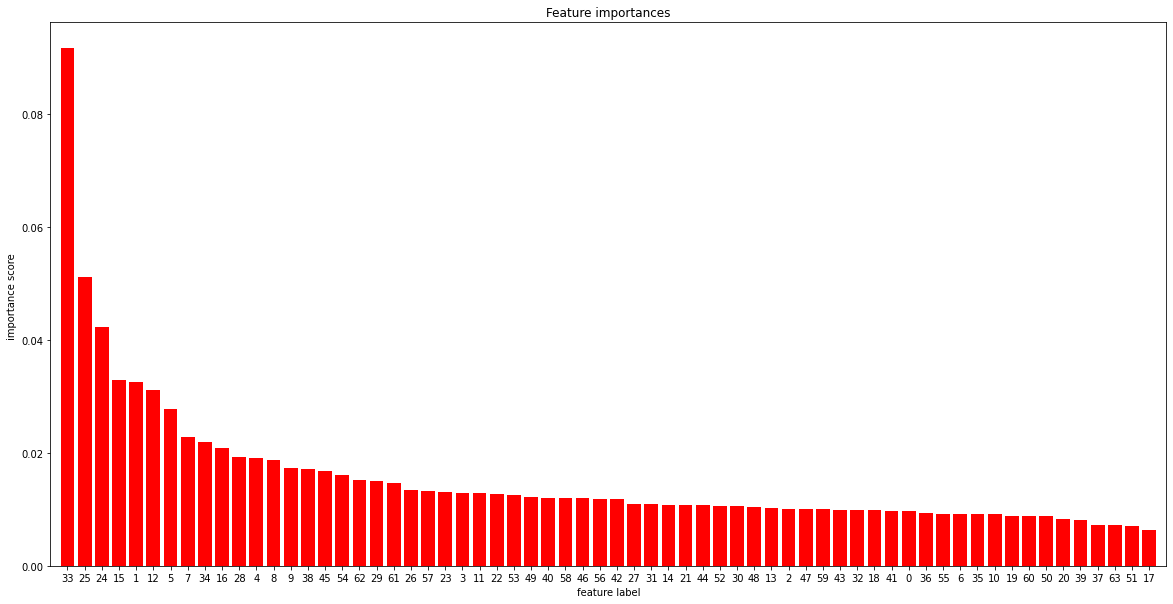

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


Index(['age', 'spiders', 'ascites', 'bilirubin', 'alk_phosphate', 'sgot',
       'albumin', 'protime'],
      dtype='object')


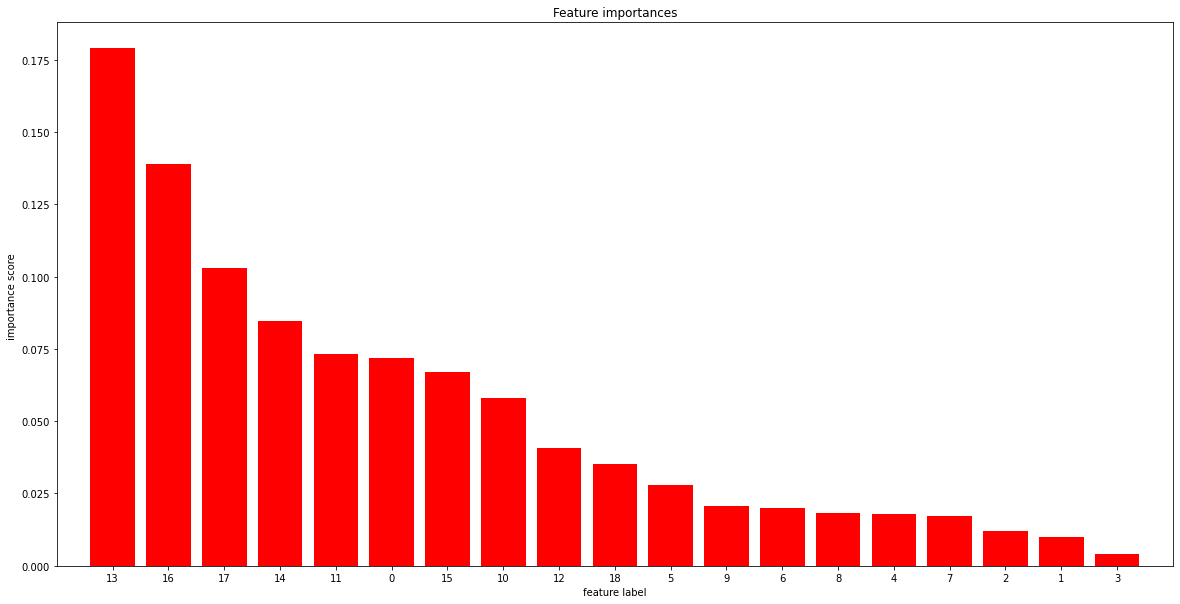

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
#shows the importance value of each feature in the dataset, yvalue is corr and xaxis is the indix number 


x=data_bank.iloc[:,:-1]
x2=data_hep.iloc[:,:-1]

yy=data_bank.iloc[:,64:65]
yy2=data_hep.iloc[:,19:20]

def feat_sel (x,y):
  sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
  sel.fit(x, y)
  sel.get_support()

  selected_feat= x.columns[(sel.get_support())]
  len(selected_feat)

  print(selected_feat)

  importances = sel.estimator_.feature_importances_
  indices = np.argsort(importances)[::-1]
  # X is the train data used to fit the model 
  plt.figure(figsize=(20,10))
  plt.title("Feature importances")
  plt.xlabel("feature label")
  plt.ylabel("importance score ")
  plt.bar(range(x.shape[1]), importances[indices],color="r", align="center")
  plt.xticks(range(x.shape[1]), indices)
  plt.xlim([-1, x.shape[1]])
  plt.show()

feat_sel(x,yy)
xx1 = data_bank[['attribute2', 'attribute5', 'attribute6', 'attribute8', 'attribute9','attribute10', 'attribute12', 'attribute13', 'attribute16','attribute17','attribute25', 'attribute26', 'attribute27','attribute29', 'attribute34', 'attribute35', 'attribute39','attribute46','ClassLabel']]
#this is the bankrupcy data after feature extraction

#hep data feature extraction 
feat_sel(x2,yy2)
xx2 = data_hep[['age', 'spiders', 'ascites', 'bilirubin', 'alk_phosphate', 'sgot','albumin', 'protime','ClassLabel']]

Dimension of X is (142, 20) ; subsequently the dimension of y is (142, 1)
The 1 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively


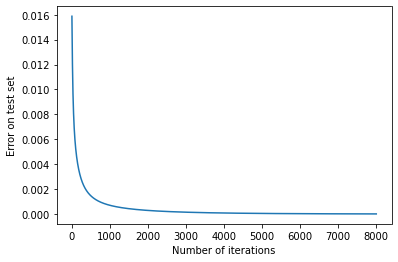

The 2 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively
The 3 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively
The 4 th fold error and accuracy are 28.57142857142857 and 71.42857142857143 respectively
The 5 th fold error and accuracy are 0.0 and 100.0 respectively
The 6 th fold error and accuracy are 42.857142857142854 and 57.14285714285714 respectively
The 7 th fold error and accuracy are 28.57142857142857 and 71.42857142857143 respectively
The 8 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively
The 9 th fold error and accuracy are 0.0 and 100.0 respectively
The 10 th fold error and accuracy are 0.0 and 100.0 respectively
The total error and accuracy of this model are 15.714285714285712 and 84.28571428571428 respectively
Time:  2.7718953599978704
# of Iterations: 8000


In [ ]:
#evaluate model on bankrupcy data after feature selection 
data_raw = data_hep
rnd_rows = rnd_rows_hep
# ================================================================
def final_model(data,rnd):
  # X = feature values, all the columns except the last column
  X_raw = data.iloc[:, 0:-1]
  # y = target values, last column of the data set
  y_raw = data.iloc[:, -1]
  # making sure all the data is float
  y_raw = y_raw.astype(float)
  # Adding the dummy features to the data set
  X_raw = np.c_[X_raw, np.ones((X_raw.shape[0], 1))]
  # Converting y to a numpy array
  y_raw = np.c_[y_raw]
  print('Dimension of X is', X_raw.shape, '; subsequently the dimension of y is', y_raw.shape)
  # ================================================================ Set Variabes
  k = 10
  order = 1
  normalization = True
  adaptive_iteration = False
  Ridge_reg = True
  Plotting = True
  # ------------------------ Adaptive iteration method
  beta = 1e0
  epsilon = 0.0001
  # ------------------------ fixed number of iteration method
  alpha = 0.0001
  num_it = 8000
  # ------------------------ Ridge Regression L2-Penalty
  l2_pen = 0.5

  # ==============================================================

  if normalization:
      X_raw = normalize_data(X_raw)
  X_raw = set_order(X_raw, order)
  X_, y_ = data_rnd_distribute(X_raw, y_raw, rnd)
  start = timeit.default_timer()  # start to calculate run time
  num_iter = cross_validate(adaptive_iteration, Ridge_reg, l2_pen, epsilon, beta, alpha, num_it, k, X_, y_)

  # -------------------------------------------------------- End
  stop = timeit.default_timer()
  print('Time: ', stop - start)
  print('# of Iterations:', num_iter)

final_model(data_raw,rnd_rows)

Dimension of X is (142, 9) ; subsequently the dimension of y is (142, 1)
The 1 th fold error and accuracy are 28.57142857142857 and 71.42857142857143 respectively


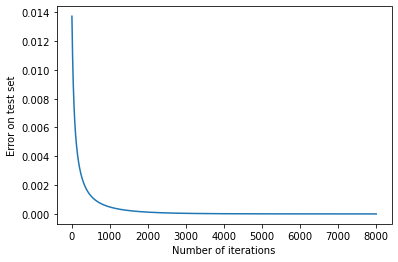

The 2 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively
The 3 th fold error and accuracy are 28.57142857142857 and 71.42857142857143 respectively
The 4 th fold error and accuracy are 28.57142857142857 and 71.42857142857143 respectively
The 5 th fold error and accuracy are 0.0 and 100.0 respectively
The 6 th fold error and accuracy are 42.857142857142854 and 57.14285714285714 respectively
The 7 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively
The 8 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively
The 9 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively
The 10 th fold error and accuracy are 0.0 and 100.0 respectively
The total error and accuracy of this model are 18.571428571428566 and 81.42857142857142 respectively
Time:  2.670919642001536
# of Iterations: 8000


In [ ]:
#hep after feature selection 
data_raw=xx2
rnd_rows=rnd_rows_hep
final_model(data_raw,rnd_rows)

In [ ]:
#check for unbalanced data 

print(data_hep.ClassLabel.value_counts())
print(data_bank.ClassLabel.value_counts())

1    116
0     26
Name: ClassLabel, dtype: int64
0    250
1    203
Name: ClassLabel, dtype: int64


1    116
0    116
Name: ClassLabel, dtype: int64
Dimension of X is (232, 20) ; subsequently the dimension of y is (232, 1)
The 1 th fold error and accuracy are 0.0 and 100.0 respectively


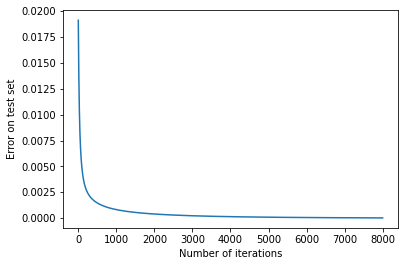

The 2 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively
The 3 th fold error and accuracy are 0.0 and 100.0 respectively
The 4 th fold error and accuracy are 0.0 and 100.0 respectively
The 5 th fold error and accuracy are 42.857142857142854 and 57.14285714285714 respectively
The 6 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively
The 7 th fold error and accuracy are 28.57142857142857 and 71.42857142857143 respectively
The 8 th fold error and accuracy are 0.0 and 100.0 respectively
The 9 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively
The 10 th fold error and accuracy are 14.285714285714285 and 85.71428571428571 respectively
The total error and accuracy of this model are 12.857142857142856 and 87.14285714285714 respectively
Time:  2.8427310300030513
# of Iterations: 8000


In [ ]:
#oversample minority class in hepatitis data 
from sklearn.utils import resample
df_majority = data_hep[data_hep.ClassLabel==1]
df_minority = data_hep[data_hep.ClassLabel==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=116,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
print(df_upsampled.ClassLabel.value_counts())

#hep after balanced data  
data_raw=df_upsampled
rnd_rows=rnd_rows_hep
final_model(data_raw,rnd_rows)

Dimension of X is (453, 65) ; subsequently the dimension of y is (453, 1)
The 1 th fold error and accuracy are 20.51282051282051 and 79.48717948717949 respectively


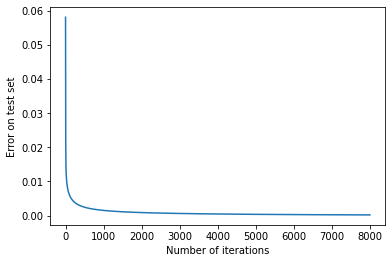

The 2 th fold error and accuracy are 20.51282051282051 and 79.48717948717949 respectively
The 3 th fold error and accuracy are 23.076923076923077 and 76.92307692307693 respectively
The 4 th fold error and accuracy are 17.94871794871795 and 82.05128205128204 respectively
The 5 th fold error and accuracy are 17.94871794871795 and 82.05128205128204 respectively
The 6 th fold error and accuracy are 23.076923076923077 and 76.92307692307693 respectively
The 7 th fold error and accuracy are 30.76923076923077 and 69.23076923076923 respectively
The 8 th fold error and accuracy are 23.076923076923077 and 76.92307692307693 respectively
The 9 th fold error and accuracy are 12.82051282051282 and 87.17948717948718 respectively
The 10 th fold error and accuracy are 15.384615384615385 and 84.61538461538461 respectively
The total error and accuracy of this model are 20.51282051282051 and 79.48717948717949 respectively
Time:  10.113477022001462
# of Iterations: 8000
Dimension of X is (453, 19) ; subsequ

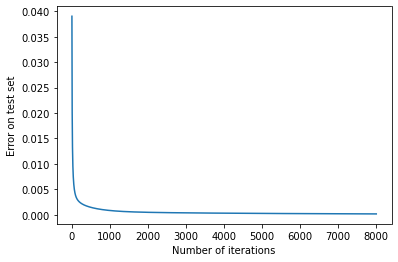

The 2 th fold error and accuracy are 25.64102564102564 and 74.35897435897436 respectively
The 3 th fold error and accuracy are 28.205128205128204 and 71.7948717948718 respectively
The 4 th fold error and accuracy are 20.51282051282051 and 79.48717948717949 respectively
The 5 th fold error and accuracy are 17.94871794871795 and 82.05128205128204 respectively
The 6 th fold error and accuracy are 28.205128205128204 and 71.7948717948718 respectively
The 7 th fold error and accuracy are 33.33333333333333 and 66.66666666666666 respectively
The 8 th fold error and accuracy are 28.205128205128204 and 71.7948717948718 respectively
The 9 th fold error and accuracy are 15.384615384615385 and 84.61538461538461 respectively
The 10 th fold error and accuracy are 20.51282051282051 and 79.48717948717949 respectively
The total error and accuracy of this model are 23.846153846153847 and 76.15384615384616 respectively
Time:  4.310115186002804
# of Iterations: 8000


In [ ]:
#bank data   
data_raw=data_bank
rnd_rows=rnd_rows_bank
final_model(data_raw,rnd_rows)

#bank data after selection   
data_raw=xx1
rnd_rows=rnd_rows_bank
final_model(data_raw,rnd_rows)

Dimension of X is (453, 65) ; subsequently the dimension of y is (453, 1)
The 1 th fold error and accuracy are 20.51282051282051 and 79.48717948717949 respectively


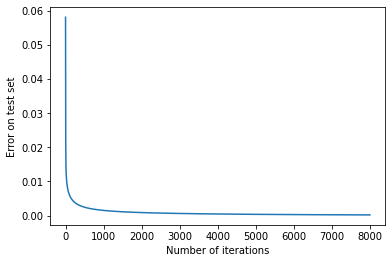

The 2 th fold error and accuracy are 20.51282051282051 and 79.48717948717949 respectively
The 3 th fold error and accuracy are 23.076923076923077 and 76.92307692307693 respectively
The 4 th fold error and accuracy are 17.94871794871795 and 82.05128205128204 respectively
The 5 th fold error and accuracy are 17.94871794871795 and 82.05128205128204 respectively
The 6 th fold error and accuracy are 23.076923076923077 and 76.92307692307693 respectively
The 7 th fold error and accuracy are 30.76923076923077 and 69.23076923076923 respectively
The 8 th fold error and accuracy are 23.076923076923077 and 76.92307692307693 respectively
The 9 th fold error and accuracy are 12.82051282051282 and 87.17948717948718 respectively
The 10 th fold error and accuracy are 15.384615384615385 and 84.61538461538461 respectively
The total error and accuracy of this model are 20.51282051282051 and 79.48717948717949 respectively
Time:  10.243668800001615
# of Iterations: 8000
this is alpha 0.0001
Dimension of X i

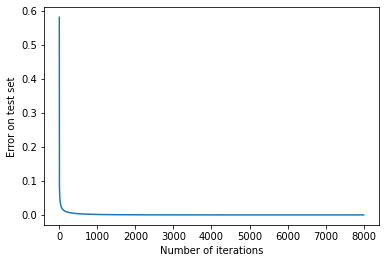

The 2 th fold error and accuracy are 20.51282051282051 and 79.48717948717949 respectively
The 3 th fold error and accuracy are 20.51282051282051 and 79.48717948717949 respectively
The 4 th fold error and accuracy are 15.384615384615385 and 84.61538461538461 respectively
The 5 th fold error and accuracy are 17.94871794871795 and 82.05128205128204 respectively
The 6 th fold error and accuracy are 23.076923076923077 and 76.92307692307693 respectively
The 7 th fold error and accuracy are 30.76923076923077 and 69.23076923076923 respectively
The 8 th fold error and accuracy are 23.076923076923077 and 76.92307692307693 respectively
The 9 th fold error and accuracy are 12.82051282051282 and 87.17948717948718 respectively
The 10 th fold error and accuracy are 15.384615384615385 and 84.61538461538461 respectively
The total error and accuracy of this model are 19.999999999999996 and 80.0 respectively
Time:  10.161392334000993
# of Iterations: 8000
this is alpha 0.001
Dimension of X is (453, 65) ;

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in exp


The 1 th fold error and accuracy are 28.205128205128204 and 71.7948717948718 respectively


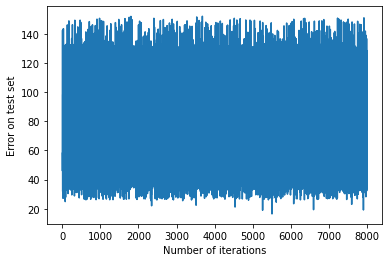

The 2 th fold error and accuracy are 30.76923076923077 and 69.23076923076923 respectively
The 3 th fold error and accuracy are 35.8974358974359 and 64.1025641025641 respectively
The 4 th fold error and accuracy are 38.46153846153847 and 61.53846153846154 respectively
The 5 th fold error and accuracy are 53.84615384615385 and 46.15384615384615 respectively
The 6 th fold error and accuracy are 33.33333333333333 and 66.66666666666666 respectively
The 7 th fold error and accuracy are 41.02564102564102 and 58.97435897435898 respectively
The 8 th fold error and accuracy are 38.46153846153847 and 61.53846153846154 respectively
The 9 th fold error and accuracy are 30.76923076923077 and 69.23076923076923 respectively
The 10 th fold error and accuracy are 25.64102564102564 and 74.35897435897436 respectively
The total error and accuracy of this model are 35.64102564102564 and 64.35897435897436 respectively
Time:  10.655103774002782
# of Iterations: 8000
this is alpha 0.1
Dimension of X is (453, 6

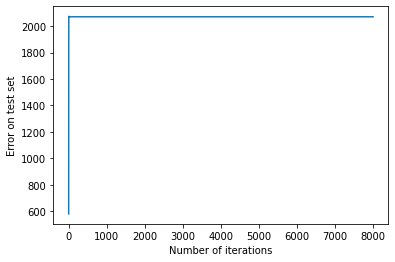

The 2 th fold error and accuracy are 61.53846153846154 and 38.46153846153847 respectively
The 3 th fold error and accuracy are 53.84615384615385 and 46.15384615384615 respectively
The 4 th fold error and accuracy are 74.35897435897436 and 25.64102564102564 respectively
The 5 th fold error and accuracy are 66.66666666666666 and 33.33333333333333 respectively
The 6 th fold error and accuracy are 71.7948717948718 and 28.205128205128204 respectively
The 7 th fold error and accuracy are 61.53846153846154 and 38.46153846153847 respectively
The 8 th fold error and accuracy are 58.97435897435898 and 41.02564102564102 respectively
The 9 th fold error and accuracy are 69.23076923076923 and 30.76923076923077 respectively
The 10 th fold error and accuracy are 71.7948717948718 and 28.205128205128204 respectively
The total error and accuracy of this model are 65.89743589743591 and 34.10256410256411 respectively
Time:  10.878689842000313
# of Iterations: 8000
this is alpha 1


In [ ]:
alpha_list = [0.0001,0.001,0.1,1]
LR=[100,500,1000,2000]
#print('alpha is. {}'.format(a))
#low alpha less accuracy of 88 and less time 1.35e-05 and higher alpha more time and similar accuracy 
for a in alpha_list:
  data_raw=data_bank
  rnd_rows=rnd_rows_bank
  k = 10
  order = 1
  normalization = True
  adaptive_iteration = False
  Ridge_reg = True
  Plotting = True
  # ------------------------ Adaptive iteration method
  beta = 1e0
  epsilon = 0.0001
  # ------------------------ fixed number of iteration method
  alpha = a
  num_it = 8000
  # ------------------------ Ridge Regression L2-Penalty
  l2_pen = 0.5
  # ==============================================================
  # X = feature values, all the columns except the last column
  X_raw = data_raw.iloc[:, 0:-1]
  # y = target values, last column of the data set
  y_raw = data_raw.iloc[:, -1]
  # making sure all the data is float
  y_raw = y_raw.astype(float)
  # Adding the dummy features to the data set
  X_raw = np.c_[X_raw, np.ones((X_raw.shape[0], 1))]
  # Converting y to a numpy array
  y_raw = np.c_[y_raw]
  print('Dimension of X is', X_raw.shape, '; subsequently the dimension of y is', y_raw.shape)

  if normalization:
    X_raw = normalize_data(X_raw)
    X_raw = set_order(X_raw, order)
    X_, y_ = data_rnd_distribute(X_raw, y_raw, rnd_rows)

    start = timeit.default_timer()  # start to calculate run time
    num_iter = cross_validate(adaptive_iteration, Ridge_reg, l2_pen, epsilon, beta, alpha, num_it, k, X_, y_)

    # -------------------------------------------------------- End
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    print('# of Iterations:', num_iter)
    print("this is alpha {}".format(a))




Dimension of X is (453, 19) ; subsequently the dimension of y is (453, 1)
The 1 th fold error and accuracy are 20.51282051282051 and 79.48717948717949 respectively


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in exp


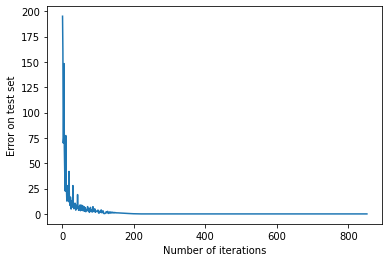

The 2 th fold error and accuracy are 25.64102564102564 and 74.35897435897436 respectively
The 3 th fold error and accuracy are 28.205128205128204 and 71.7948717948718 respectively
The 4 th fold error and accuracy are 20.51282051282051 and 79.48717948717949 respectively
The 5 th fold error and accuracy are 17.94871794871795 and 82.05128205128204 respectively
The 6 th fold error and accuracy are 28.205128205128204 and 71.7948717948718 respectively
The 7 th fold error and accuracy are 33.33333333333333 and 66.66666666666666 respectively
The 8 th fold error and accuracy are 28.205128205128204 and 71.7948717948718 respectively
The 9 th fold error and accuracy are 15.384615384615385 and 84.61538461538461 respectively
The 10 th fold error and accuracy are 20.51282051282051 and 79.48717948717949 respectively
The total error and accuracy of this model are 23.846153846153847 and 76.15384615384616 respectively
Time:  0.6707443579998653
# of Iterations: 923


In [ ]:
#adaptive learning 
data_raw = xx1
rnd_rows = rnd_rows_bank
# ================================================================
def final_model(data,rnd):
  # X = feature values, all the columns except the last column
  X_raw = data.iloc[:, 0:-1]
  # y = target values, last column of the data set
  y_raw = data.iloc[:, -1]
  # making sure all the data is float
  y_raw = y_raw.astype(float)
  # Adding the dummy features to the data set
  X_raw = np.c_[X_raw, np.ones((X_raw.shape[0], 1))]
  # Converting y to a numpy array
  y_raw = np.c_[y_raw]
  print('Dimension of X is', X_raw.shape, '; subsequently the dimension of y is', y_raw.shape)
  # ================================================================ Set Variabes
  k = 10
  order = 1
  normalization = True
  adaptive_iteration = True
  Ridge_reg = True
  Plotting = True
  # ------------------------ Adaptive iteration method
  beta = 1e0
  epsilon = 0.0001
  # ------------------------ fixed number of iteration method
  alpha = 0.001
  num_it = 8000
  # ------------------------ Ridge Regression L2-Penalty
  l2_pen = 0.5

  # ==============================================================

  if normalization:
      X_raw = normalize_data(X_raw)
  X_raw = set_order(X_raw, order)
  X_, y_ = data_rnd_distribute(X_raw, y_raw, rnd)
  start = timeit.default_timer()  # start to calculate run time
  num_iter = cross_validate(adaptive_iteration, Ridge_reg, l2_pen, epsilon, beta, alpha, num_it, k, X_, y_)

  # -------------------------------------------------------- End
  stop = timeit.default_timer()
  print('Time: ', stop - start)
  print('# of Iterations:', num_iter)

final_model(data_raw,rnd_rows)